In [1]:
import numpy as np
from util import PVect, time_func, z_func
import torch
import matplotlib.pyplot as plot
from reco import process_data,prepare_data_for_nn

Using device cuda:0


In [2]:
v = PVect()
v.setVector(1,0,0.1,1)

In [3]:
v.theta

84.28940686250034

July 5th data (50 z pos)

In [4]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

# inputs = torch.load(Timing_path + "data/July_05/Run_0/Vary_p_2000events_file_0_July_5_50_z_pos.pt")
# for i in range(1,51):
#     inputs = torch.cat((inputs, torch.load(Timing_path + f"data/July_05/Run_0/Vary_p_2000events_file_{i}_July_5_50_z_pos.pt")),0)

July 18th data (200 z pos)

In [5]:
Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

inputs = torch.load(Timing_path + "data/July_18/Run_0/Vary_p_1000events_file_0_July_18_200_z_pos.pt")
for i in range(1,201):
    inputs = torch.cat((inputs, torch.load(Timing_path + f"data/July_18/Run_0/Vary_p_1000events_file_{i}_July_18_200_z_pos.pt")),0)

In [6]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.8
train_lim = int(np.floor(dataset.shape[0] * train_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:]

In [7]:
train_data.shape

torch.Size([65065148, 5])

Text(0.5, 0, 'momentum (GeV/c)')

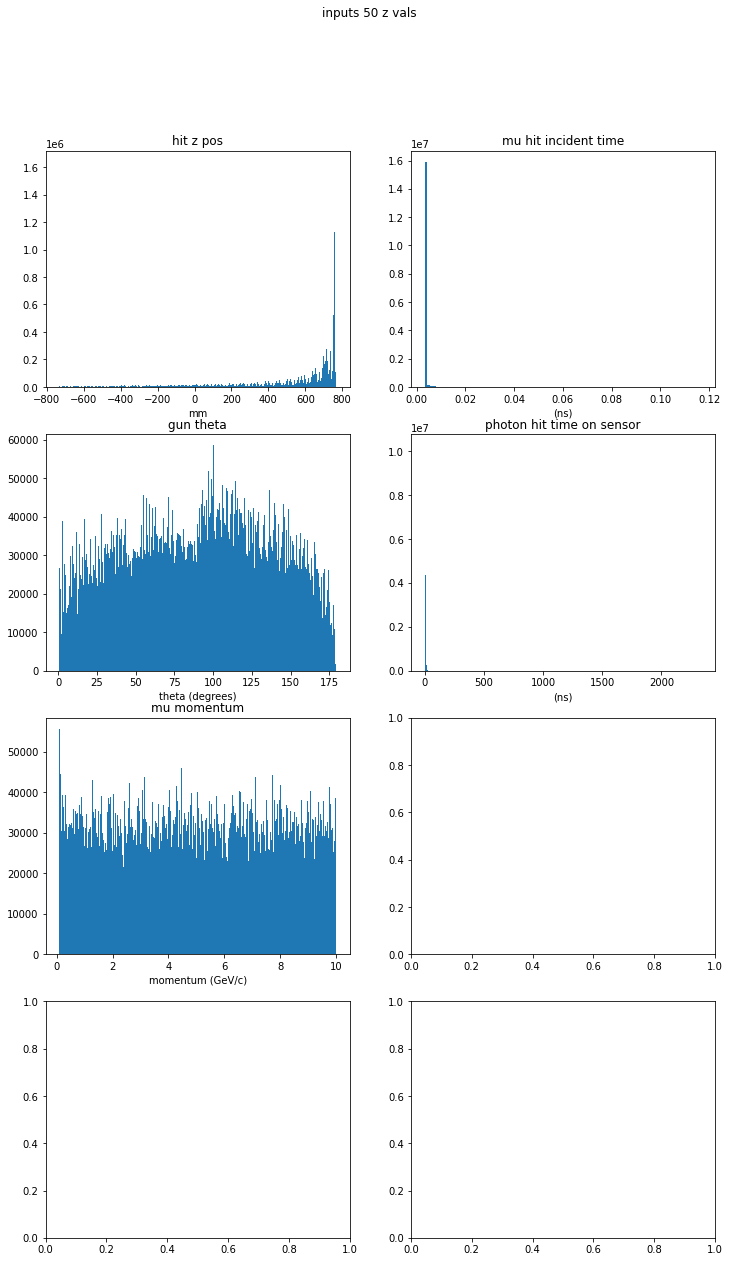

In [61]:
fig, axs = plot.subplots(4,2,figsize = (12,20))
fig.suptitle("inputs 50 z vals")
axs[0,0].hist(test_data[:,0],bins = 500);
axs[0,0].set_title("hit z pos")
axs[0,0].set_xlabel("mm")
axs[0,1].hist(test_data[:,1],bins = 100)
axs[0,1].set_title("mu hit incident time")
axs[0,1].set_xlabel("(ns)")

axs[1,0].hist(test_data[:,2],bins = 500);
axs[1,0].set_title("gun theta")
axs[1,0].set_xlabel("theta (degrees)")
axs[1,1].hist(test_data[:,4],bins = 500);
axs[1,1].set_title("photon hit time on sensor")
axs[1,1].set_xlabel("(ns)")

# axs[2,0].hist2d(test_data[:,2],test_data[:,1],bins = 500);
# axs[2,0].set_title("theta vs mu hit incident time")
# axs[2,0].set_xlabel("theta")
# axs[2,0].set_ylabel("mu hit incident time")
# axs[2,1].hist2d(test_data[:,0], test_data[:,4],bins = 500);
# axs[2,1].set_title("photon hit time on sensor vs z hit position")
# axs[2,1].set_xlabel("z hit pos (mm)")
# axs[2,1].set_ylabel("photon hit time on sensor (ns)")

axs[2,0].hist(test_data[:,3],bins = 500);
axs[2,0].set_title("mu momentum")
axs[2,0].set_xlabel("momentum (GeV/c)")

In [62]:
fig.savefig("plots/inputs/July_18/test_set_200_z_pos_data.pdf")

In [2]:
import uproot as up
from reco import create_unique_mapping
num_layers = 28
from util import get_layer, create_layer_map,calculate_num_pixels_z_dependence
layer_map, super_layer_map = create_layer_map()

In [39]:
def process_data(uproot_path, file_num=0, particle="pion"):
    data = []
    events = up.open(uproot_path)
    
    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')
    x_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.x"].array(library='np')
    y_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.y"].array(library='np')
    z_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.z"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    time_branch = events["HcalBarrelHits.time"].array(library='np')   
    num_events = len(x_pos_branch)
    for event_idx in range(num_events):
        Hits_MC_idx_event = Hits_MC_idx_branch[event_idx]
        PDG_event = PDG_branch[event_idx]
        n_unique_parts, idx_dict = create_unique_mapping(Hits_MC_idx_event)
        
        p_layer_list = np.ones((n_unique_parts,num_layers)) * -1
        z_hit_layer_list = np.ones((n_unique_parts,num_layers)) * -1
        theta_layer_list = np.ones((n_unique_parts,num_layers)) * -1
        hit_time_layer_list = np.ones((n_unique_parts,num_layers)) * -1
        edep_event = np.ones((n_unique_parts,num_layers)) * -1
        PDG_list = np.ones((n_unique_parts,num_layers)) * -1
        
        x_pos_event = x_pos_branch[event_idx]
        px_event = x_momentum_branch[event_idx]
        py_event = y_momentum_branch[event_idx]
        pz_event = z_momentum_branch[event_idx]
        z_event = z_pos_branch[event_idx]
        time_event = time_branch[event_idx]
        EDep_event = EDep_branch[event_idx]
        for hit_idx in range(len(x_pos_event)):
            idx = Hits_MC_idx_branch[event_idx][hit_idx]
            part_idx = idx_dict[idx]
            layer_idx = get_layer(x_pos_event[hit_idx], super_layer_map)
            if layer_idx == -1: #error handling for get_layer
                continue
            elif p_layer_list[part_idx,layer_idx] == -1:
                p_layer_list[part_idx,layer_idx] = np.sqrt(px_event[hit_idx]**2 + py_event[hit_idx]**2 + pz_event[hit_idx]**2)
                z_hit_layer_list[part_idx,layer_idx] = z_event[hit_idx]
                theta_layer_list[part_idx,layer_idx] = np.arctan2(np.sqrt(px_event[hit_idx]**2 + py_event[hit_idx]**2), pz_event[hit_idx])
                hit_time_layer_list[part_idx,layer_idx] = time_event[hit_idx]
                edep_event[part_idx,layer_idx] = EDep_event[hit_idx]
                PDG_list[part_idx,layer_idx] = PDG_event[part_idx]
            else:
                edep_event[part_idx,layer_idx] += EDep_event[hit_idx]
        data.append(np.stack([z_hit_layer_list,hit_time_layer_list,theta_layer_list,p_layer_list,PDG_list,(np.floor(calculate_num_pixels_z_dependence(edep_event,z_hit_layer_list)).astype(int))],axis = -1))


    
    return data #returns list: each entry is a diff event array; each event array has shape: (#unique particles, #layers, #features)
                #features: z hit, hit time, theta, p, energy dep
    

from torch.utils.data import TensorDataset, DataLoader

def prepare_data_for_nn(processed_data):
    all_features = []
    all_metadata = []
    
    for event_idx, event_data in enumerate(processed_data):
        if(event_idx > 1000):
            break
        for particle_idx in range(event_data.shape[0]):
            for layer_idx in range(event_data.shape[1]):
                features = event_data[particle_idx, layer_idx, :5]  # Get first 4 features
                repeat_count = int(event_data[particle_idx, layer_idx, 5])  # Get 5th feature as repeat count
                
                #cuts
                if(features[1] > 50):
                    continue
                
                
                if not np.any(features == -1) and repeat_count > 0:  # Check if all features are -1 and repeat_count is valid
                    # Repeat the features and metadata by repeat_count
                    all_features.extend([features] * repeat_count)
                    all_metadata.extend([(event_idx, particle_idx, layer_idx)] * repeat_count)
    
    # Convert to numpy arrays
    features_array = np.array(all_features)
    metadata_array = np.array(all_metadata)
    
    return features_array, metadata_array

In [40]:
up_path = f"/cwork/rck32/eic/work_eic/root_files/July_18/mu_5GeV_10k_vary_th_phi_p.edm4hep.root:events"
data = process_data(up_path)

nn_data = prepare_data_for_nn(data)

In [41]:
nn_data[0].shape

(309017514, 5)

Text(0.5, 0, '(GeV/c)')

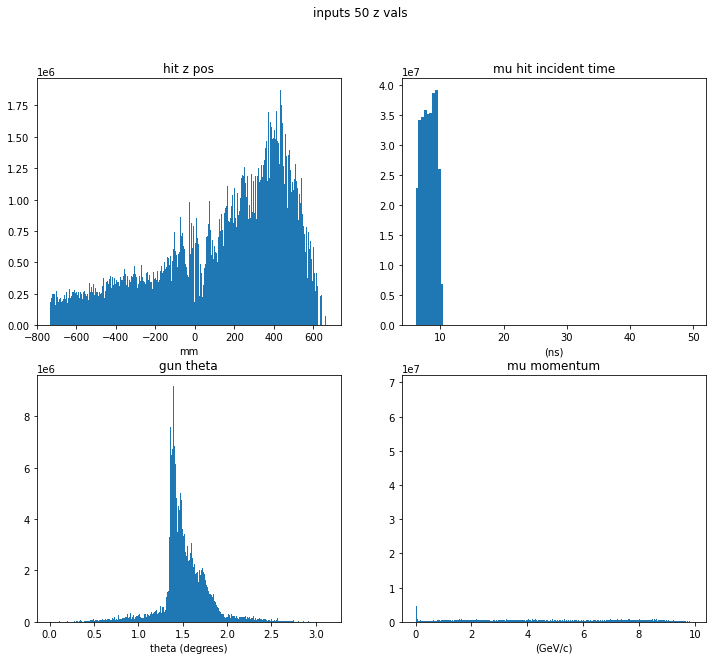

In [42]:
fig, axs = plot.subplots(2,2,figsize = (12,10))
fig.suptitle("inputs 50 z vals")
axs[0,0].hist(nn_data[0][:,0],bins = 500);
axs[0,0].set_title("hit z pos")
axs[0,0].set_xlabel("mm")
axs[0,1].hist(nn_data[0][:,1],bins = 100)
axs[0,1].set_title("mu hit incident time")
axs[0,1].set_xlabel("(ns)")

axs[1,0].hist(nn_data[0][:,2],bins = 500);
axs[1,0].set_title("gun theta")
axs[1,0].set_xlabel("theta (degrees)")
axs[1,1].hist(nn_data[0][:,3],bins = 500);
axs[1,1].set_title("mu momentum")
axs[1,1].set_xlabel("(GeV/c)")

# axs[2,0].hist2d(data[:,2],data[:,1],bins = 500);
# axs[2,0].set_title("theta vs mu hit incident time")
# axs[2,0].set_xlabel("theta")
# axs[2,0].set_ylabel("mu hit incident time")
# axs[2,1].hist2d(data[:,0], data[:,4],bins = 500);
# axs[2,1].set_title("photon hit time on sensor vs z hit position")
# axs[2,1].set_xlabel("z hit pos (mm)")
# axs[2,1].set_ylabel("photon hit time on sensor (ns)")

# axs[2,0].hist(data[:,3],bins = 500);
# axs[2,0].set_title("mu momentum")
# axs[2,0].set_xlabel("momentum (GeV/c)")

In [27]:
e_data = nn_data[0][nn_data[0][:,4] == 11]
e_data_small_p = e_data[e_data[:,3] < 0.01]

In [28]:
mu_data = nn_data[0][nn_data[0][:,4] == 13]
mu_data_small_p = mu_data[mu_data[:,3] < 0.01]

In [29]:
len(mu_data_small_p) / len(mu_data)

1.5982505228655164e-05

In [30]:
len(e_data_small_p) / len(e_data)

0.802375146032678

In [31]:
pdg_set = set(nn_data[0][:,4])

In [32]:
pdg_set

{-11.0, 11.0, 13.0, 22.0, 1000260560.0}

In [37]:
ph_data = nn_data[0][nn_data[0][:,4] == 1000260560]
len(ph_data) / len(nn_data[0])

0.0004232762323169865

percent of photons making it to sensor in full sim: 2880.0


In [45]:
num_optph_per_event = 9000 * 10 ** 3 / 15

In [46]:
print(f"percent of photons making it to sensor in full sim: {2500 / num_optph_per_event * 100}")

percent of photons making it to sensor in full sim: 0.4166666666666667


In [48]:
opt_ph_per_sec_sim = 5000 / 6
opt_ph_per_sec_NF = 86000
print(f"rate of sim: {opt_ph_per_sec_sim} optph/second | rate of NF: {opt_ph_per_sec_NF} optph/second | speedup: {opt_ph_per_sec_NF / opt_ph_per_sec_sim}")

rate of sim: 833.3333333333334 optph/second | rate of NF: 86000 optph/second | speedup: 103.19999999999999
